In [48]:
using Plots
using LinearAlgebra
using Parameters 
using Statistics
using Test
import Base.+
import Base.*
import Base./
import Base.conj

In [19]:
module My

using Parameters

@with_kw struct PhysicalParam 
    Nsite::Int64 = 4 # number of site in each direction
    Nthermal::Int64 = 1000
    Nsweep::Int64 = 1000
    β::Float64 = 1.0
end


end # module My


Main.My

In [21]:
param = My.PhysicalParam()

Main.My.PhysicalParam
  Nsite: Int64 4
  Nthermal: Int64 1000
  Nsweep: Int64 1000
  β: Float64 1.0


## $SU(2)$

representation:
$$
    U = a_{0} + i \vec{a} \cdot \vec{\sigma} 
    = \left( 
    \begin{array}
    a_{0} + i a_{3} & i a_{1} + a_{2} \\
    i a_{1} - a_{2} & a_{0} - i a_{3}
    \end{array}
    \right)
$$


multiplication:
$$
    (a_{0} + \vec{a} \cdot \vec{\sigma}) (b_{0} + \vec{b} \cdot \vec{\sigma}) 
    = (a_{0} b_{0} - \vec{a} \cdot \vec{b}) 
    + i (\vec{a} b_{0} + a_{0} \vec{b} - \vec{a} \times \vec{b}) \cdot \vec{\sigma}
$$

In [4]:
struct SU2
    a₀::Float64
    a₁::Float64
    a₂::Float64
    a₃::Float64
end

In [101]:
function *(U::SU2, V::SU2)
    a₀ = U.a₀*V.a₀ - (U.a₁*V.a₁ + U.a₂*V.a₂ + U.a₃*V.a₃)
    
    a₁ = U.a₁*V.a₀ + U.a₀*V.a₁ - (U.a₂*V.a₃ - U.a₃*V.a₂)
    a₂ = U.a₂*V.a₀ + U.a₀*V.a₂ - (U.a₃*V.a₁ - U.a₁*V.a₃)
    a₃ = U.a₃*V.a₀ + U.a₀*V.a₃ - (U.a₁*V.a₂ - U.a₂*V.a₁)
    
    SU2(a₀, a₁, a₂, a₃)
end

*(U::SU2, x) = SU2(U.a₀*x, U.a₁*x, U.a₂*x, U.a₃*x)
*(x, U::SU2) = *(U, x)
/(U::SU2, x) = *(U, 1/x)

function +(U::SU2, V::SU2)
    a₀ = U.a₀ + V.a₀
    a₁ = U.a₁ + V.a₁
    a₂ = U.a₂ + V.a₂
    a₃ = U.a₃ + V.a₃
    
    SU2(a₀, a₁, a₂, a₃)
end

function abs2(U::SU2)
    return U.a₀*U.a₀ + U.a₁*U.a₁ + U.a₂*U.a₂ + U.a₃*U.a₃
end

abs(U::SU2) = sqrt(abs2(U))

conj(U::SU2) = SU2(U.a₀, -U.a₁, -U.a₂, -U.a₃)

trace(U::SU2) = 2U.a₀

trace (generic function with 1 method)

In [53]:
U = SU2(1,0,0,0)
V = SU2(1,0,0,0)

#@time mul(U, V)
@time U*V

#@time add(U, V)
@time U+V

@time abs(U)

@time U = SU2(1/sqrt(2), 1/sqrt(2), 0, 0)
@time U*conj(U)

  0.009985 seconds (236 allocations: 14.969 KiB, 99.89% compilation time)
  0.009880 seconds (62 allocations: 4.062 KiB, 99.93% compilation time)
  0.000001 seconds
  0.000001 seconds (1 allocation: 48 bytes)
  0.005577 seconds (40 allocations: 2.688 KiB, 99.64% compilation time)


SU2(0.9999999999999998, 0.0, 0.0, 0.0)

In [91]:
function initial_gaugefields(param; random=false)
    @unpack Nsite = param
    
    Us = Array{SU2}(undef, Nsite, Nsite, Nsite, Nsite, 4)
    for μ in 1:4, n₄ in 1:Nsite, n₃ in 1:Nsite, n₂ in 1:Nsite, n₁ in 1:Nsite 
        Us[n₁, n₂, n₃, n₄, μ] = SU2(1,0,0,0)
    end
    
    if random 
        for μ in 1:4, n₄ in 1:Nsite, n₃ in 1:Nsite, n₂ in 1:Nsite, n₁ in 1:Nsite 
            a₀ = 2*rand() - 1
        
            cosθ = 2*rand() - 1
            sinθ = sqrt(1 - cosθ^2)
            ϕ = 2π*rand()

            a = sqrt(1 - a₀^2)
            a₁ = a*sinθ*cos(ϕ)
            a₂ = a*sinθ*sin(ϕ)
            a₃ = a*cosθ
            
            U = SU2(a₀, a₁, a₂, a₃)
            Us[n₁, n₂, n₃, n₄, μ] = U
            
            #@show abs(U*conj(U)) 
        end
    end
    
    return Us
end

initial_gaugefields (generic function with 1 method)

In [93]:
@time initial_gaugefields(param; random=true);

  0.000081 seconds (3 allocations: 32.125 KiB)


In [87]:
function update!(Us, param)
    @unpack Nsite, β = param 
    
    δ(μ, ν) = ifelse(μ===ν,1,0)
    
    function f(n)
        if n < 1 
            return Nsite 
        elseif n > Nsite 
            return 1
        else
            return n
        end
    end
    
    for μ in 1:4, n₄ in 1:Nsite, n₃ in 1:Nsite, n₂ in 1:Nsite, n₁ in 1:Nsite
        
        U_staple = SU2(0,0,0,0)
        for ν in 1:4
            if ν === μ continue end 
            
            U₁ =      Us[f(n₁+δ(1,μ)), f(n₂+δ(2,μ)), f(n₃+δ(3,μ)), f(n₄+δ(4,μ)), ν]
            U₂ = conj(Us[f(n₁+δ(1,ν)), f(n₂+δ(2,ν)), f(n₃+δ(3,ν)), f(n₄+δ(4,ν)), μ])
            U₃ = conj(Us[n₁, n₂, n₃, n₄, ν])
            U_staple += U₁*U₂*U₃
            #@show abs(U₁*U₂*U₃)
            #U_staple = add(U_staple, mul(U₁, mul(U₂, U₃)))
            
            U₁ = conj(Us[f(n₁+δ(1,μ)-δ(1,ν)), f(n₂+δ(2,μ)-δ(2,ν)), f(n₃+δ(3,μ)-δ(3,ν)), f(n₄+δ(4,μ)-δ(4,ν)), ν])
            U₂ = conj(Us[f(n₁-δ(1,ν)), f(n₂-δ(2,ν)), f(n₃-δ(3,ν)), f(n₄-δ(4,ν)), μ])
            U₃ = Us[f(n₁-δ(1,ν)), f(n₂-δ(2,ν)), f(n₃-δ(3,ν)), f(n₄-δ(4,ν)), ν]
            U_staple += U₁*U₂*U₃
            #@show abs(U₁*U₂*U₃)
            #U_staple = add(U_staple, mul(U₁, mul(U₂, U₃)))
        end
        k = abs(U_staple) 
        
        accept = false
        temp1 = exp(β*k)
        temp2 = exp(-β*k)
        z = temp2
        while(!accept)
            z = (temp1 - temp2)*rand() + temp2
            y = rand()
            if y ≤ sqrt(1 - (log(z)/(β*k))^2)
                accept = true
                break
            end
        end
        
        a₀ = log(z)/(β*k)
        
        cosθ = 2*rand() - 1
        sinθ = sqrt(1 - cosθ^2)
        ϕ = 2π*rand()

        a = sqrt(1 - a₀^2)
        a₁ = a*sinθ*cos(ϕ)
        a₂ = a*sinθ*sin(ϕ)
        a₃ = a*cosθ
        
        U = SU2(a₀, a₁, a₂, a₃)
        
        Us[n₁, n₂, n₃, n₄, μ] = U*conj(U_staple)/k
        #@show abs(Us[n₁, n₂, n₃, n₄, μ])
    end 
end
                
        
        

update! (generic function with 1 method)

In [90]:
Us = initial_gaugefields(param)
@time update!(Us, param)
;

  0.000638 seconds


In [97]:
function calc_average_plaquette(param, Us)
    @unpack Nsite = param
    
    δ(μ, ν) = ifelse(μ===ν,1,0)
    
    function f(n)
        if n < 1 
            return Nsite 
        elseif n > Nsite 
            return 1
        else
            return n
        end
    end
    
    P = 0.0
    
    for ν in 1:4, μ in 1:ν-1, n₄ in 1:Nsite, n₃ in 1:Nsite, n₂ in 1:Nsite, n₁ in 1:Nsite
        U₁ = Us[n₁, n₂, n₃, n₄, μ]
        U₂ = Us[f(n₁+δ(1,μ)), f(n₂+δ(2,μ)), f(n₃+δ(3,μ)), f(n₄+δ(4,μ)), ν]
        U₃ = conj(Us[f(n₁+δ(1,ν)), f(n₂+δ(2,ν)), f(n₃+δ(3,ν)), f(n₄+δ(4,ν)), μ])
        U₄ = conj(Us[n₁, n₂, n₃, n₄, ν])
        U = U₁*U₂*U₃*U₄
        P += 1 - trace(U)/2
    end
    
    P /= 6*Nsite^4
    return P
end

calc_average_plaquette (generic function with 1 method)

In [103]:
param = My.PhysicalParam(Nsite=4)
Us = initial_gaugefields(param; random=false)
@time P = calc_average_plaquette(param, Us)
@show P
;

  0.000080 seconds (1 allocation: 16 bytes)
P = 0.0


In [104]:
function test_thermalization(param)
    @unpack Nsite, Nthermal, Nsweep = param
    
    # ordered start
    Us_ordered = initial_gaugefields(param)
    
    Ps_ordered = zeros(Float64, Nthermal)
    Ps_average_ordered = zeros(Float64, Nthermal)
    
    @time for isweep in 1:Nthermal
        update!(Us_ordered, param)
        Ps_ordered[isweep] = calc_average_plaquette(param, Us_ordered)
        if isweep === 1
            Ps_average_ordered[isweep] = Ps_ordered[isweep]
        else
            Ps_average_ordered[isweep] = Ps_average_ordered[isweep-1]*(isweep-1) + Ps_ordered[isweep]
            Ps_average_ordered[isweep] /= isweep
        end
    end
    
    # random start
    Us_random = initial_gaugefields(param; random=true)
    
    Ps_random = zeros(Float64, Nthermal)
    Ps_average_random = zeros(Float64, Nthermal)
    
    @time for isweep in 1:Nthermal
        update!(Us_random, param)
        Ps_random[isweep] = calc_average_plaquette(param, Us_random)
        if isweep === 1
            Ps_average_random[isweep] = Ps_random[isweep]
        else
            Ps_average_random[isweep] = Ps_average_random[isweep-1]*(isweep-1) + Ps_random[isweep]
            Ps_average_random[isweep] /= isweep
        end
    end
    
    # plot 
    p = plot(xlabel="iteration", ylabel="average plaquette")
    plot!(p, Ps_average_ordered; label="ordered start")
    plot!(p, Ps_average_random; label="random start")
end

test_thermalization (generic function with 1 method)

  1.848540 seconds
  1.851489 seconds


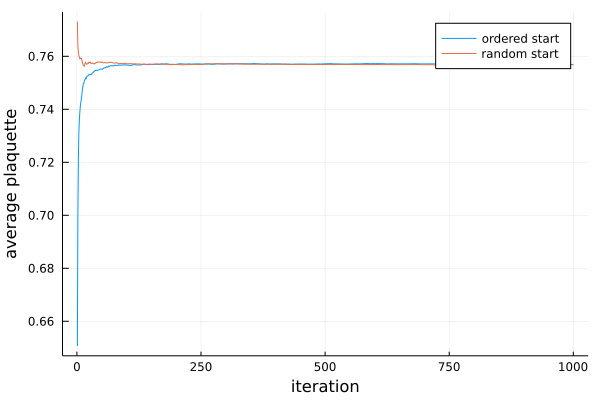

In [105]:
param = My.PhysicalParam(Nsite=6, β=1.0, Nthermal=1000)
test_thermalization(param)

In [106]:
function do_heat_bath(param; random=false)
    @unpack Nsite, Nthermal, Nsweep = param
    
    Us = initial_gaugefields(param; random=random)
    
    # thermalization
    for isweep in 1:Nthermal
        update!(Us, param)
    end
    
    # measurement
    Ps = zeros(Float64, Nsweep)
    for isweep in 1:Nthermal
        update!(Us, param)
        Ps[isweep] = calc_average_plaquette(param, Us)
    end
    
    P = mean(Ps)
    ΔP = stdm(Ps, P)
    return P, ΔP
end

do_heat_bath (generic function with 1 method)

In [117]:
param = My.PhysicalParam(Nthermal=1000, Nsweep=1000, Nsite=5)

#βs = range(0, 2, length=20+1)[2:end]
βs = 10 .^ range(-1, 1, length=50+1)

Ps_ordered = zeros(Float64, length(βs))
ΔPs_ordered = zeros(Float64, length(βs))

Ps_random = zeros(Float64, length(βs))
ΔPs_random = zeros(Float64, length(βs))

for iβ in 1:length(βs)
    param = My.PhysicalParam(param, β=βs[iβ])
    
    @time P, ΔP = do_heat_bath(param; random=false)
    Ps_ordered[iβ] = P
    ΔPs_ordered[iβ] = ΔP
    
    @time P, ΔP = do_heat_bath(param; random=true)
    Ps_random[iβ] = P
    ΔPs_random[iβ] = ΔP
end

  1.705057 seconds (9 allocations: 86.312 KiB)
  1.708993 seconds (9 allocations: 86.312 KiB)
  1.673470 seconds (9 allocations: 86.312 KiB)
  1.691155 seconds (9 allocations: 86.312 KiB)
  1.667965 seconds (9 allocations: 86.312 KiB)
  1.638643 seconds (9 allocations: 86.312 KiB)
  1.748135 seconds (9 allocations: 86.312 KiB)
  1.800896 seconds (9 allocations: 86.312 KiB)
  1.759981 seconds (9 allocations: 86.312 KiB)
  1.858231 seconds (9 allocations: 86.312 KiB)
  2.040114 seconds (9 allocations: 86.312 KiB)
  1.823795 seconds (9 allocations: 86.312 KiB)
  1.629472 seconds (9 allocations: 86.312 KiB)
  1.648825 seconds (9 allocations: 86.312 KiB)
  1.620491 seconds (9 allocations: 86.312 KiB)
  1.621676 seconds (9 allocations: 86.312 KiB)
  1.619401 seconds (9 allocations: 86.312 KiB)
  1.631951 seconds (9 allocations: 86.312 KiB)
  1.636004 seconds (9 allocations: 86.312 KiB)
  1.619556 seconds (9 allocations: 86.312 KiB)
  1.620861 seconds (9 allocations: 86.312 KiB)
  1.618644 se

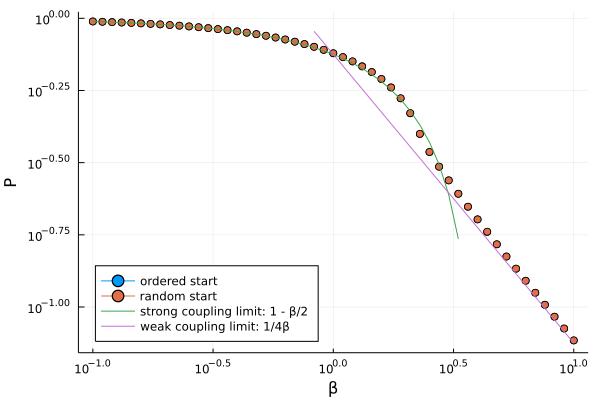

In [118]:
p = plot(xlabel="β", xaxis=:log, yaxis=:log, ylabel="P", legend=:bottomleft)
plot!(p, βs, Ps_ordered; marker=:dot, line=false, label="ordered start")
plot!(p, βs, Ps_random; marker=:dot, line=false, label="random start")


f(x) = ifelse(x<3.5, 1-x/4, NaN)
plot!(p, βs, f.(βs), label="strong coupling limit: 1 - β/2")

g(x) = ifelse(x>0.8, 3/4x,  NaN)
plot!(p, βs, g.(βs), label="weak coupling limit: 1/4β")

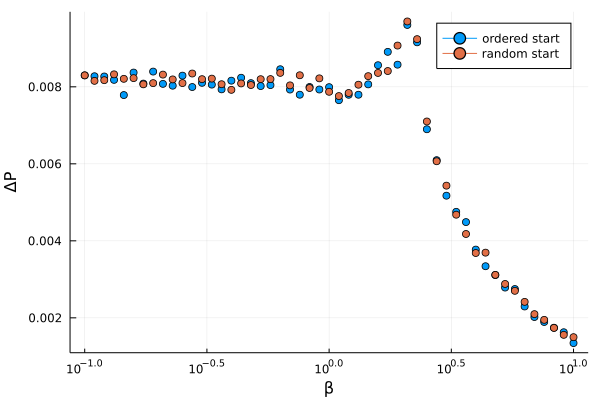

In [119]:
p = plot(xlabel="β", xaxis=:log, ylabel="ΔP")
plot!(p, βs, ΔPs_ordered; marker=:dot, line=false, label="ordered start")
plot!(p, βs, ΔPs_random; marker=:dot, line=false, label="random start")